## Dataset gen

In [1]:
import numpy as np
import os
from shutil import copy

In [2]:
base_dir = "./Datasets/main/"
for category in ["glacier/","mountain/"]:
    files = os.listdir(base_dir+category)
    test = files[:int(len(files)/4)]
    train = files[int(len(files)/4):]
    for file in test:
        copy(base_dir+category+file, base_dir+"test/"+category+file)
    for file in train:
        copy(base_dir+category+file, base_dir+"train/"+category+file)

In [3]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [4]:
def preprocess(x):
    X=np.expand_dims(x,axis=0)
    X=preprocess_input(X)
    return X[0]

In [5]:
data_gen=image.ImageDataGenerator(rotation_range=30,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  zoom_range=0.2,
                                  preprocessing_function=preprocess)

In [6]:
base_dir = "./Datasets/main/"
train_generator=data_gen.flow_from_directory(os.path.join(base_dir,"train"),target_size=(150,150))
valid_generator=data_gen.flow_from_directory(os.path.join(base_dir,"test"),target_size=(150,150))

Found 809 images belonging to 2 classes.
Found 269 images belonging to 2 classes.


## Model creation:

In [7]:
from keras.applications.vgg16 import VGG16
# from keras.preprocessing.image import load_img, img_to_array
from keras import Model
from keras.layers import Flatten, Dense

In [8]:
vgg = VGG16(include_top=False, input_shape=(150,150,3))

flatten = Flatten()(vgg.layers[-1].output)
intermediate = Dense(units=1000, activation='relu')(flatten)
# using softmax instead of sigmoid as ImageDataGenerator from keras loads the labels with dimension 2 here.
prediction = Dense(units=2, activation='softmax')(intermediate)

model = Model(inputs = vgg.input, outputs = prediction)

for layer in model.layers[:len(vgg.layers)]:
    layer.trainable  = False

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [10]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])

In [11]:
model.fit_generator(
    train_generator,
    epochs=5,verbose=1,validation_data=valid_generator,shuffle=False,
    steps_per_epoch=len(train_generator),validation_steps=len(valid_generator))

Epoch 1/5
26/26 [==============================] - 55s 2s/step - loss: 8.4203 - accuracy: 0.7281 - val_loss: 2.8014 - val_accuracy: 0.8030
Epoch 2/5
26/26 [==============================] - 55s 2s/step - loss: 0.7959 - accuracy: 0.8405 - val_loss: 0.4908 - val_accuracy: 0.8104
Epoch 3/5
26/26 [==============================] - 53s 2s/step - loss: 0.3590 - accuracy: 0.8640 - val_loss: 0.7873 - val_accuracy: 0.8364
Epoch 4/5
26/26 [==============================] - 56s 2s/step - loss: 0.3032 - accuracy: 0.8863 - val_loss: 0.7367 - val_accuracy: 0.8439
Epoch 5/5
26/26 [==============================] - 55s 2s/step - loss: 0.1983 - accuracy: 0.9159 - val_loss: 0.8131 - val_accuracy: 0.8030


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

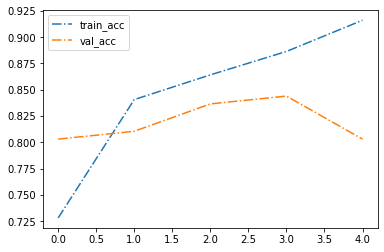

In [13]:
plt.plot(model.history.history['accuracy'], '-.', label="train_acc")
plt.plot(model.history.history['val_accuracy'], '-.', label="val_acc")
plt.legend()
plt.savefig("./acc.png")

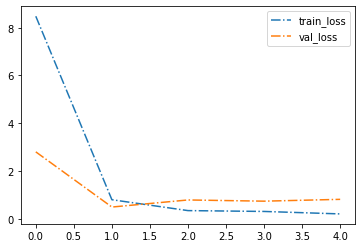

In [14]:
plt.plot(model.history.history['loss'], '-.', label="train_loss")
plt.plot(model.history.history['val_loss'], '-.', label="val_loss")
plt.legend()
plt.savefig("./loss.png")